## Лузина Владимира РИС22-2
# Динамические регрессионные модели

Для учета инертности системы во времени используют аппарат передаточных функций или
дифференциальных уравнений. В данной работе используя статистические данные необходимо
оценить изменение объема продаж при изменении цены с помощью звеньев запаздывания первого
порядка и звена запаздывания второго порядка.
Такое предположение будет означать, что изменение цены происходит как реакция на изменение объема
продаж по некоторому алгоритму

Дополнительно необходимо рассмотреть автокорреляцию выборки с разными вариантами смещения
у всех лагов по сравнению с базовой выборкой
необходимо рассмотреть корреляцию, детерминацию и проверить по критерию фишера
После чего необходимо построить регрессионную модель значимого по критерию фишера ряда
и определить его параметр детерминации.

Я не стал удалять выбросы, так как это не связано с текущей задачей и этого не было на семинаре,
но почти наверняка их нужно будет что-то сделать с ними в реальной задаче (не обязательно удалить)

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy

Исходные данные взяты также из варианта 25

In [242]:
#df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
#                   'price': [1.81, 1.81, 3.78, 3.78, 3.78, 3.78, 3.78, 3.89, 3.93, 3.28, 3.23, 3.21, 3.35, 3.35, 3.37,
#                             3.40, 3.25, 3.25, 3.25, 3.29],  # стоимость
#                   'amount': [28, 21, 3, 0, 27, 14, 10, 2, 2, 8, 15, 10, 17, 9, 2, 33, 1, 12, 10, 4]})  # число продаж

df = pd.DataFrame({'day': [i for i in range(1, 21)],  # дни с 1 по 20
                  'price': [4.1, 4.1, 4.37, 4.37, 4.37, 4.37, 4.37, 4.55, 4.61, 4.39, 4.33, 4.31, 4.49, 4.49, 4.53,
                            4.57, 4.38, 4.38, 4.38, 4.42],  # стоимость
                  'amount': [20, 34, 16, 16, 25, 47, 41, 26, 29, 17, 75, 42, 46, 58, 7, 18, 27, 88, 61,31]})  # число продаж
df

,day,price,amount
0,1,4.10,20
1,2,4.10,34
2,3,4.37,16
3,4,4.37,16
4,5,4.37,25
5,6,4.37,47
6,7,4.37,41
7,8,4.55,26
8,9,4.61,29
9,10,4.39,17


### Линейная многопараметрическая модель

Для учета инертности системы во времени используют аппарат передаточных функций или дифференциальных уравнений. В данной работе используя статистические данные необходимо оценить изменение объема продаж при изменении цены с помощью звеньев запаздывания первого порядка
Объём продаж зависит от накопленной цены 

Построим матрицу A, включив в неё накопленные суммы
S(x) - накопленный объём цен
S(y) - накопленное количество продаж

In [243]:
sm = 0
ls_pr = []
for i in range(len(df)):
    sm += df["price"][i]
    ls_pr.append(round(sm,2))

sm = 0
ls_am = []
for i in range(len(df)):
    sm += df["amount"][i]
    ls_am.append(round(sm,2))
A = pd.DataFrame({"S(x)": ls_pr, "S(y)": ls_am})

A

,S(x),S(y)
0,4.10,20
1,8.20,54
2,12.57,70
3,16.94,86
4,21.31,111
5,25.68,158
6,30.05,199
7,34.60,225
8,39.21,254
9,43.60,271


In [244]:
y = df["amount"]

Теперь воспользуемся формулой для расчёта коэффициентов регрессионной модели

In [245]:
C = (np.linalg.inv(A.T @ A) @ A.T) @ y
C

0    1.320302
1   -0.085044
dtype: float64

Каждая единица накопленной цены увеличивает объём продаж на 1.32
Каждая единица накопленной объёма продаж уменьшает объём продаж на 0.09

In [246]:
def pred_first(s_x: float, s_y: float) -> float:
    return C[0]*s_x + C[1]*s_y

Построим диаграмму рассеяния и линии регрессии, полученной с
использованием передаточного звена первого порядка

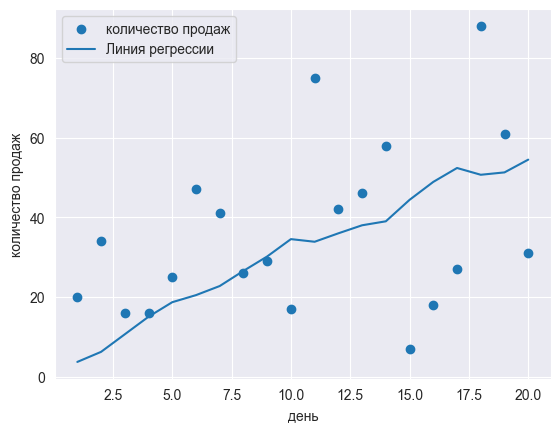

In [247]:
plt.scatter(df["day"], df["amount"], label='количество продаж')
plt.plot(df["day"], pred_first(A["S(x)"], A["S(y)"]), label='Линия регрессии')
plt.xlabel('день')
plt.ylabel('количество продаж')
plt.legend()
plt.show()

### Сумма накопленных сум

Построим матрицу A, включив в неё накопленные суммы
S(S(x)) - накопленная сумма сум цен
S(S(y)) - накопленная сумма сум объёма продаж (двойное суммирование)

In [248]:
sm = 0
ls_pr_pr = []
for i in ls_pr:
    sm += i
    ls_pr_pr.append(round(sm,2))

sm = 0
ls_am_am = []
for i in ls_am:
    sm += i
    ls_am_am.append(round(sm,2))
    
A = pd.DataFrame({"S(S(x))": ls_pr_pr, "S(y)": ls_am,"S(S(y))": ls_am_am})

A

,S(S(x)),S(y),S(S(y))
0,4.10,20,20
1,12.30,54,74
2,24.87,70,144
3,41.81,86,230
4,63.12,111,341
5,88.80,158,499
6,118.85,199,698
7,153.45,225,923
8,192.66,254,1177
9,236.26,271,1448


In [249]:
y = df["amount"]

Теперь воспользуемся формулой для расчёта коэффициентов регрессионной модели

In [250]:
C = (np.linalg.inv(A.T @ A) @ A.T) @ y
C

0   -0.978584
1    0.458133
2    0.090870
dtype: float64

Единица накопленного прироста цены приводит к уменьшению объёма продаж на единицу
Накопленная величина объёма продаж приводит к увеличению объёма продаж на 0.46 
Накопленный прирост объёма продаж увеличивает объём продаж на 0.09

In [251]:
def pred_second(s_s_x: float, s_y: float, s_s_y: float) -> float:
    return C[0]*s_s_x + C[1]*s_y + C[2] * s_s_y

Диаграмма рассеяния и линии регрессии, полученной с
использованием передаточного звена второго порядка

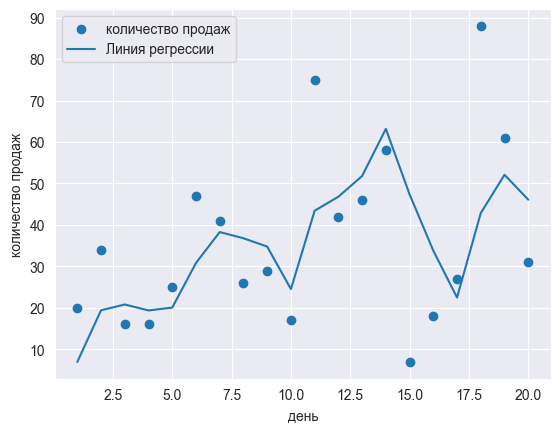

In [252]:
plt.scatter(df["day"], df["amount"], label='количество продаж')
plt.plot(df["day"], pred_second(A["S(S(x))"], A["S(y)"], A["S(S(y))"]), label='Линия регрессии')
plt.xlabel('день')
plt.ylabel('количество продаж')
plt.legend()
plt.show()

### Автокорреляция
Для этого нужно рассмотреть разные варианты смещения
(от 1 до выбранного значения) временной лаг
чем больше выбранное значение, тем меньше вариантность найти корреляцию
Корреляция вычисляется между разными уровнями временного ряда
Сначала необходимо найти корреляция, затем детерминация и критерии фишера


Дано количество потребляемой энергии за 2 года (24 месяца) на производстве
в данные заложена информация, что каждые 5 месяцев производство расширяется
(корреляция между 0 и 5 лагом)

In [253]:
#df = pd.Series([6,8,9,2,10,14,14,8,14,17,16,12,19,23,22,14,24,28,24,17,28,33,30])
df = pd.Series([8,6,9,7,8,14,13,15,12,13,19,19,20,19,18,24,25,25,26,26,31,30,29,30])

Рассмотрим смещения от 1 до 6 и добавим в датафрейм их корреляции и детерминации
Также по критерию фишера найдём значимые корреляции
a - уровень значимости, возьмём за 0.05

In [254]:
a = 0.05
# автокорреляция с лагом от 1 до 6 включительно
correlations = []
for i in range(1,6+1):
    correlations.append(df.autocorr(lag=i))

# детерминации с лагом от 1 до 6 включительно
determinations = []
for i in correlations:
    determinations.append(i**2)

atr = pd.DataFrame({"corr": correlations, "determ": determinations})

# Критерий фишера
# оп
atr = atr.copy()
op = []
for i in range(6):
    d = atr["determ"][i]
    n = len(df) - i - 1
    m = 1
    op.append(d/(1-d) * ((n - m - 1) / m))

# критическое
crit = []
for i in range(6):
    n = len(df) - i - 1
    m = 1
    crit.append(scipy.stats.f.ppf(q=1-a, dfn = n, dfd = m))
atr["op"] = op
atr["crit"] = crit

bool_meaning = [] # True - значима, False - нет
for i in range(len(atr)):
    bool_meaning.append(bool(atr["op"][i] > atr["crit"][i]))
atr["meaning"] = bool_meaning
atr

,corr,determ,op,crit,meaning
0,0.944175,0.891466,172.487418,248.825572,False
1,0.916790,0.840504,105.394610,248.579059,False
2,0.909785,0.827708,91.277924,248.309371,False
3,0.915950,0.838964,93.776500,248.013082,False
4,0.985601,0.971410,577.614760,247.686054,True
5,0.908223,0.824869,75.360417,247.323244,False


Итого, можно сделать вывод, что смещение (lag) на 5 значения значимо относительно начальных данных
То есть через каждые 5 месяцев происходит скачок в потреблении электроэнергии

Найдём коэффициенты этой зависимости
$X_{I+5} = c_1 + c_2 * x_i$

In [255]:
A = pd.DataFrame({"A": [1 for i in range(len(df)-5)], "val": [i for i in df[:len(df)-5]]})
y = pd.DataFrame({"y": df[5:]}).reset_index().drop(columns=["index"])

In [256]:
C = (np.linalg.inv(A.T @ A) @ A.T) @ y
C

,y
0,6.325989
1,0.959354


По этим параметрам модели можно сделать вывод, что
модель прогнозирует каждые 5 месяцев увеличение среднего
потребления электроэнергии на 6.3 условных единиц
а потребление на нулевом пятимесячном сроке будет 0.96

In [260]:
def regression(day: float) -> float:
    return C["y"][0]*(day//6) + C["y"][1]

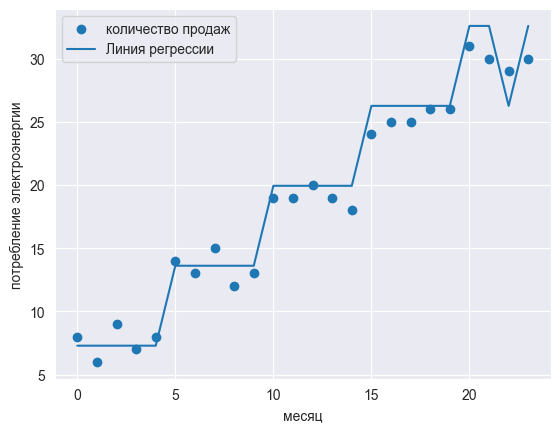

In [261]:
plt.scatter(df.index, df, label='количество продаж')
plt.plot(df.index, regression(df), label='Линия регрессии')
plt.xlabel('месяц')
plt.ylabel('потребление электроэнергии')
plt.legend()
plt.show()

### коэффициент детерминации

In [262]:
coef_determ = r2_score(A["val"], pd.Series([regression(i) for i in A["val"]]))
coef_determ

0.9663333125173584

Чем ближе значение модели к 1 тем она точнее
В нашем же случае прогнозирование очень точное
в 97 случаях из 100 будет верное предсказание
(квадрат корреляции)